In [1]:
pip install -q cleanvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow.keras import layers
from cleanvision import Imagelab
from matplotlib import ticker
from PIL import Image 
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For reproducability
SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Customize matplotlib graphs
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

# Introduction
Breast cancer is the most prevalent form of cancer, accounting for 2,261,419(11.7%) of the **19,292,789** cases reported worldwide in 2020 
-- Global Cancer Observatory.

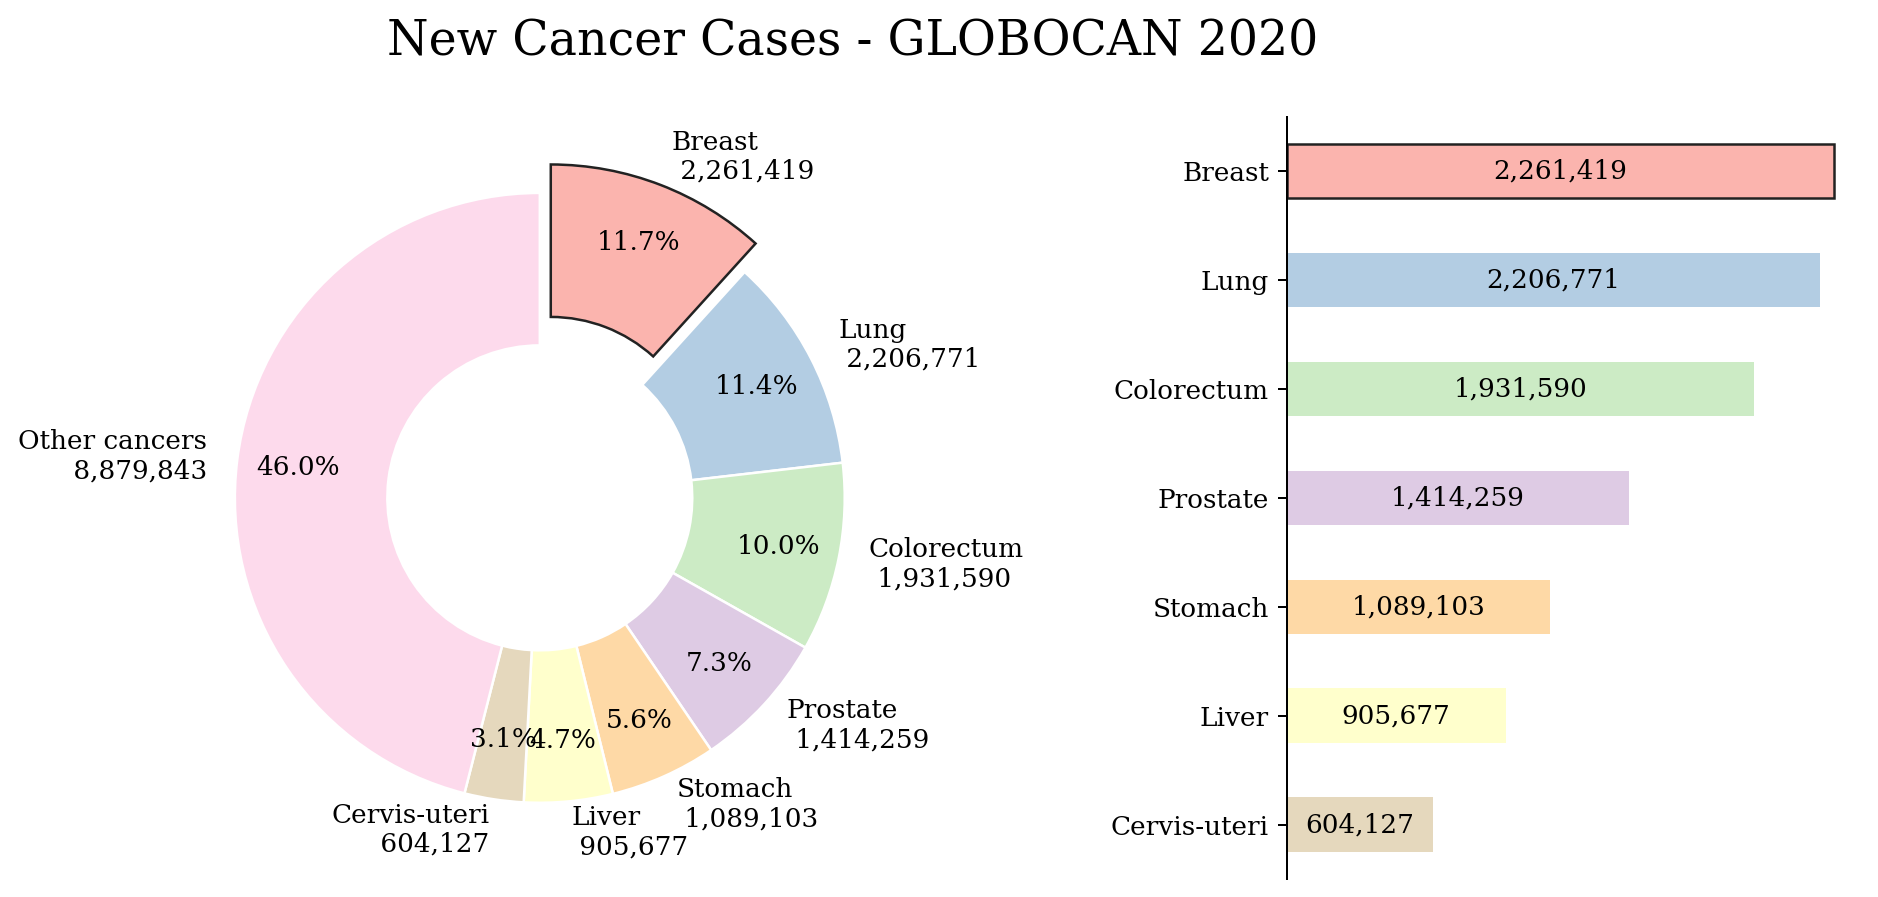

In [3]:
cancer_data = pd.Series({
    "Breast": 2261419,
    "Lung": 2206771,
    "Colorectum": 1931590,
    "Prostate": 1414259,
    "Stomach": 1089103,
    "Liver": 905677,
    "Cervis-uteri": 604127,
    "Other cancers": 8879843
})
fig, axes = plt.subplot_mosaic("aab", figsize=(14, 5.5), dpi=180)
fig.suptitle("New Cancer Cases - GLOBOCAN 2020", size=19, weight=500)
pie_chart = cancer_data.plot.pie(
    colors=plt.colormaps["Pastel1"].colors, 
    startangle=90,
    autopct=lambda x: f"{x:.1f}%",
    pctdistance=0.8,
    explode=[0.1] + [0]*7,
    counterclock=False,
    ax=axes["a"], 
    wedgeprops=dict(width=0.5, edgecolor='w'),
    labels=[f"{kind}\n {count:,}"
            for kind, count in cancer_data.items()])
axes["a"].axis("off")

cancer_data_specific = cancer_data.drop("Other cancers").sort_values()
bar_chart = cancer_data_specific.plot.barh(ax=axes["b"],
                                          color=plt.colormaps["Pastel1"].colors[-3:: -1])
bar_chart.bar_label(bar_chart.containers[0], [f"{x:,}" for x in cancer_data_specific],
                   label_type="center"
                   )
axes["b"].spines["bottom"].set_visible(False)
axes["a"].patches[0].set_edgecolor("#222")
axes["b"].patches[-1].set_edgecolor("#222")
axes["b"].xaxis.set_visible(False);

Early detection of cancer is crucial in ensuring the best chances of recovery. Machine learning can enable fast, scable diagnosis without the need for an extensive team of healthcare professionals.

# Aim / Purpose

To create a diagnostic tool that uses computer vision models to reliably distinguish between benign breast tumours from malignant (cancerous) ones, given histopathological images. 

# Data Source

The [Breast Cancer Histopathological Database (BreakHis)](https://www.kaggle.com/datasets/ambarish/breakhis)
> Spanhol, F., Oliveira, L. S., Petitjean, C., Heutte, L., A Dataset for Breast Cancer Histopathological Image Classification, IEEE Transactions on Biomedical Engineering (TBME), 63(7):1455-1462, 2016.
https://www.inf.ufpr.br/lesoliveira/download/TBME-00608-2015-R2-preprint.pdf

The dataset consists of 7,909 microscopic images of breast tumour tissue collected from 82 patients at various magnification factors.

- Benign:
    - Adenosis (A)
    - Fibroadenoma (F)
    - Phyllodes tumour (PT)
    - Tubular adenoma (TA)
- Malignant:
    - Carcinoma (DC)
    - Lobular carcinoma (LC)
    - Mucinous carcinoma (MC)
    - Papillary carcinoma (PC)
    
Samples were obtained via [surgical open biopsy](https://myhealth.alberta.ca/Health/aftercareinformation/pages/conditions.aspx?hwid=ud3329), and subjected to the following: 
- *fixation, dehydration, clearing, infiltration, embedding, and trimming*
- *precision slicing* to 3um sections using a microtome*
- *staining* with hematoxylin and eosin, then covered with a glass coverslip
- *visual inspection* under a microscope by anatomopathologists to identify tumoral areas
- *final diagnosis* of each case by experienced pathologists
- confirmation by *complementary exams* such as immunohistochemistry analysis
- digital photography


# Data Analysis

The files [Folds.csv] outlines a 5-fold cross-validation strategy which was designed such that training and test images are from different individuals:

In [4]:
fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info.head()

fold  mag    grp                                           filename   label
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign

Each fold contains all 7,909 available images. We will use the second fold for this study, since it has the highest proportion of images:

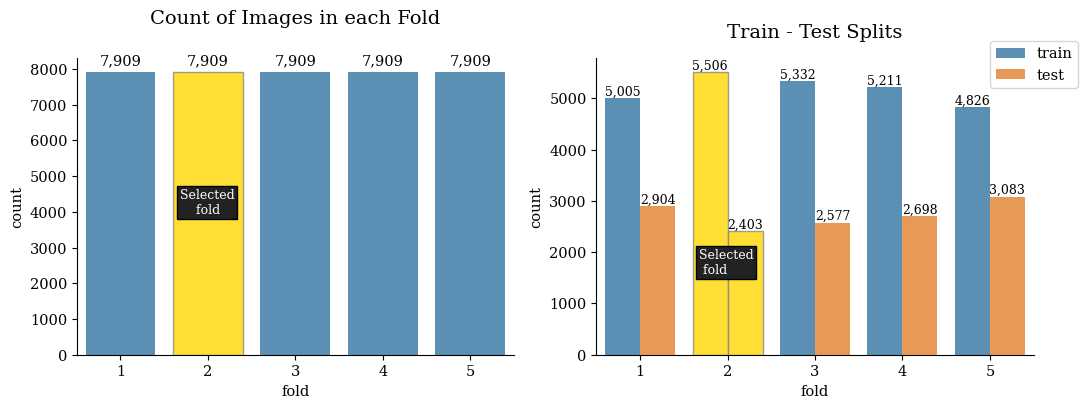

In [5]:
selected_fold = 2 
selected_fold_data = fold_info.query("fold == @selected_fold")\
                              .copy().reset_index(drop=True)
selected_fold_data["filename"] = ("/kaggle/input/breakhis/BreaKHis_v1/" + selected_fold_data["filename"])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)

# Plot image count in each fold
sb.countplot(data=fold_info, x="fold", color="C0", ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, padding=3, labels=[f"{x:,.0f}" for x in bars.datavalues])

_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("gold")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.08, _selected_bar.get_height() / 2,
        "Selected\n    fold", size=9, color="#fff",
        bbox={"pad": 2, "facecolor": "#222"})
ax1.set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=fold_info, x="fold", hue="grp", palette="tab10",
            ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("gold")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.07, _selected_bar.get_height() / 5,
        "Selected\n fold", size=9, color="#fff",
        bbox={"pad": 2, "facecolor": "#222"})
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9));

# Magnification Factors

[Previous Work](https://www.mdpi.com/2571-5577/5/5/87),
> Ashtaiwi, A. Optimal Histopathological Magnification Factors for Deep Learning-Based Breast Cancer Prediction. Appl. Syst. Innov. 2022, 5, 87. https://doi.org/10.3390/asi5050087

on the subject, established that training models on images with magnification factor at least **200X** yields the best results. 

Consider the following images from slide 22549AB at different magnification factors: 


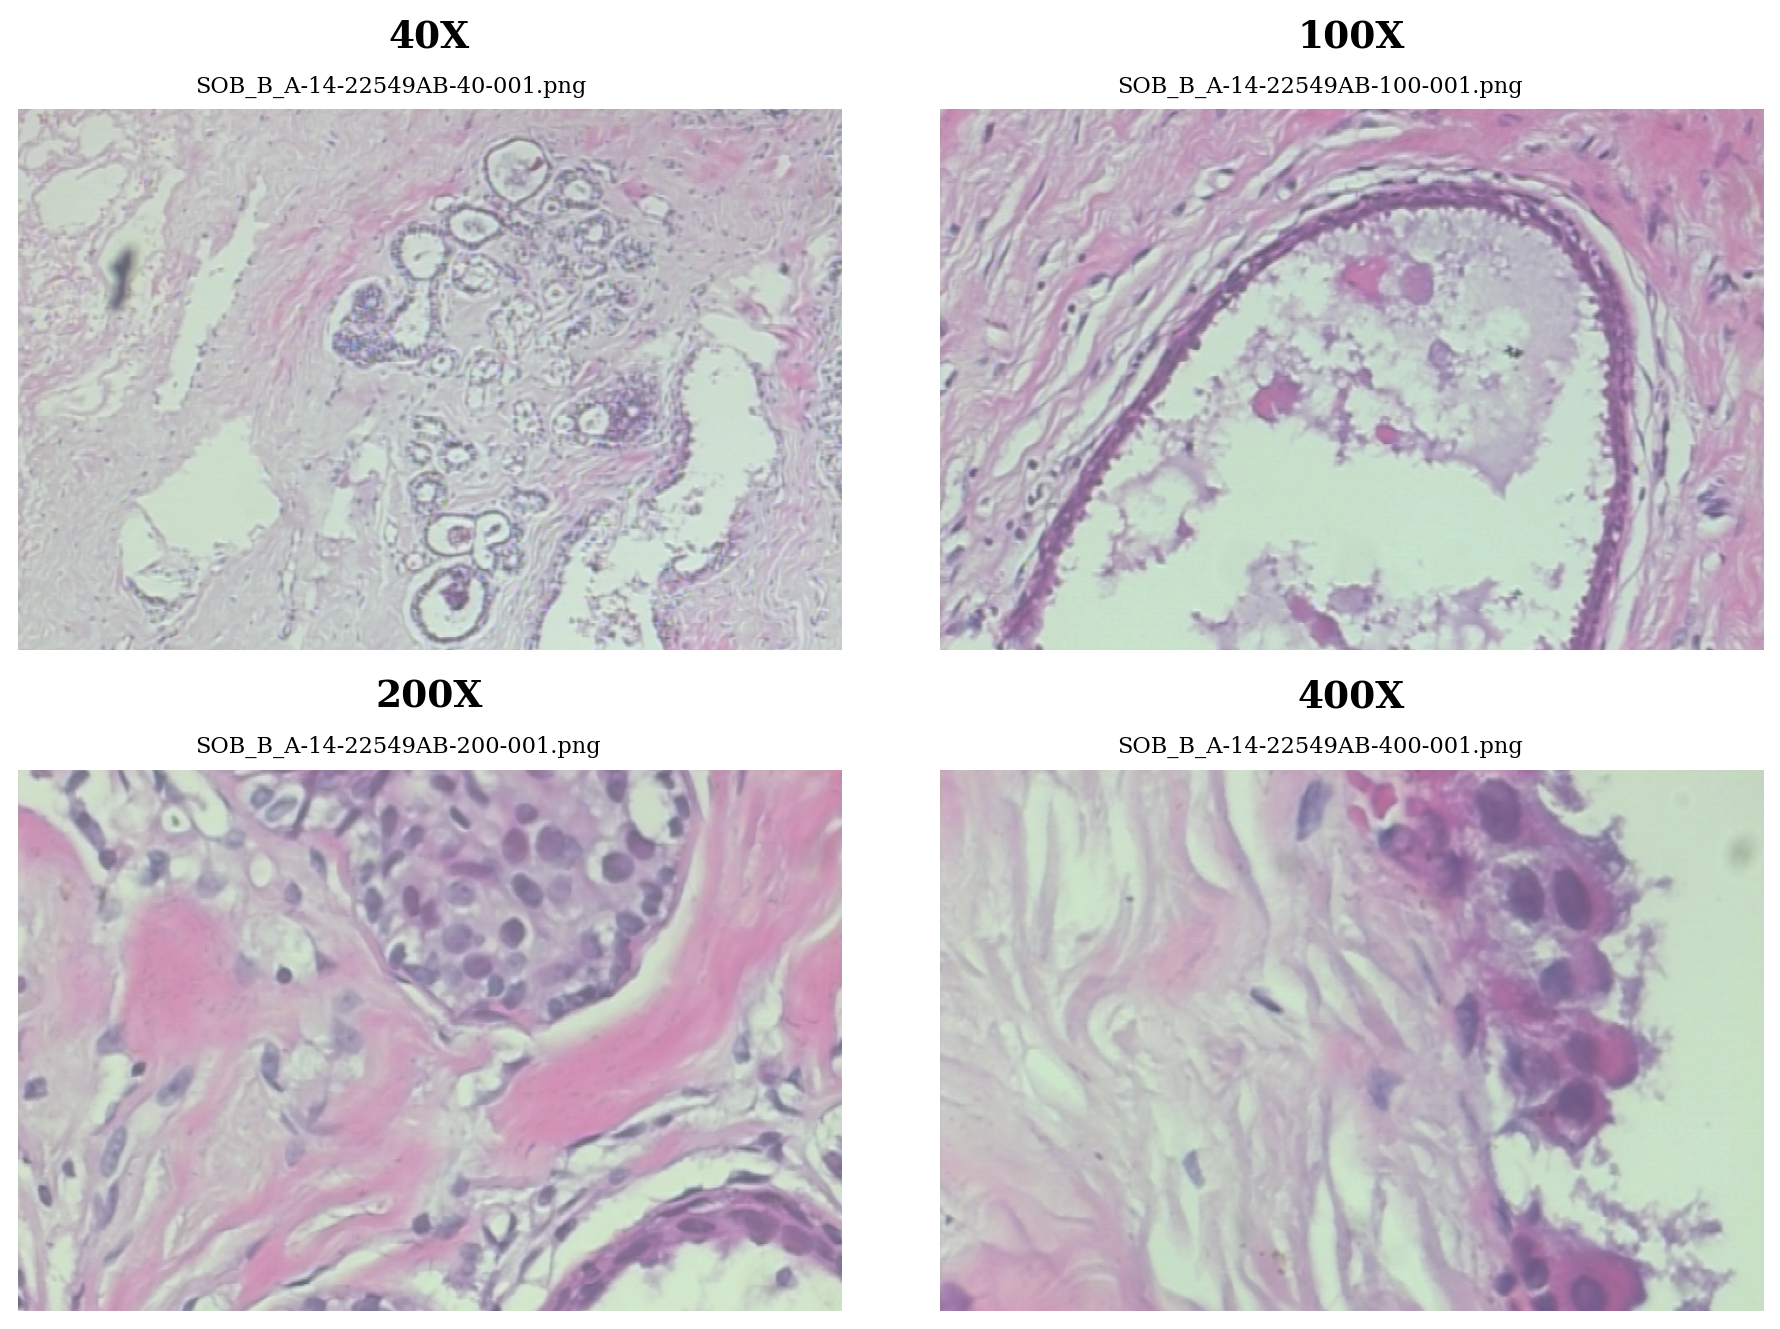

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = selected_fold_data.groupby("mag", as_index=False).first() 
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

# Image Validation

There are about 256 (3.16%) duplicate images. On further inspection, duplicated pairs have similar slide-ID but different tumour types; this can possibly suggest that those slides capture more than 1 tumour type or perhaps also human error. 

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 256 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | near_duplicates  |            6 |
|  2 | blurry           |            0 |
|  3 | dark             |            0 |
|  4 | grayscale        |            0 |
|  5 | light            |            0 |
|  6 | low_information  |            0 |
|  7 | odd_aspect_ratio |            0 |
|  8 | odd_size         |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


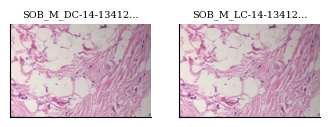

Set: 1


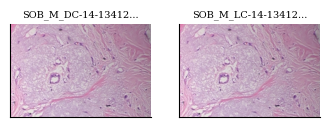

Set: 2


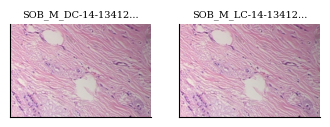

Set: 3


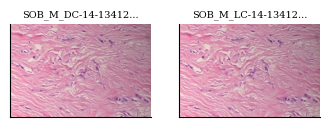

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


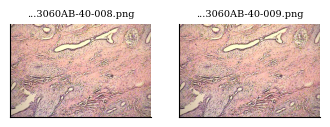

Set: 1


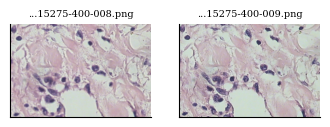

Set: 2


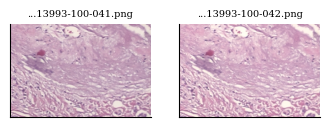

In [7]:
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)

In [11]:
duplicated_images = imagelab.issues[
    ["is_exact_duplicates_issue", "is_near_duplicates_issue"]
].any(axis=1).reset_index().rename(columns={"index": "filename", 0: "duplicated"})
duplicated_images.head()

filename  duplicated
0  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False
1  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False
2  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False
3  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False
4  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...       False

In [12]:
# Check that filenames align
assert duplicated_images["filename"].equals(selected_fold_data["filename"])

# Drop all duplicated images, then validate again
selected_fold_data = selected_fold_data[~duplicated_images["duplicated"]]
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7653 [00:00<?, ?it/s]

  0%|          | 0/7653 [00:00<?, ?it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


In [13]:
# Use data in selected fold (2) with magnification factor >= 200X
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >=200 and grp == 'test'")
train.shape, test.shape

((2566, 5), (1149, 5))

# Target Distribution
There are significantly more images of malignant cases than there are of benign ones:

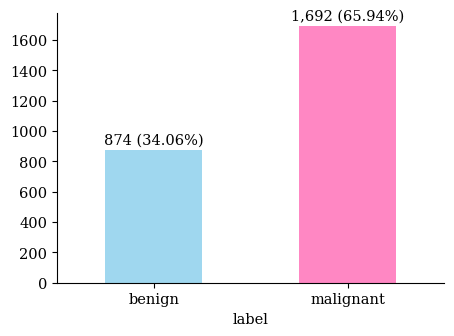

In [14]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                          figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=2,
            labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

Where there is a class *imabalance* in a classification problem, accuracy is an unreliable metric; it becomes easy to achieve high accuracy by just predicting more of the majority class. 

To illustrate this, a classifier predicting only *malignant* (1) would get an accuracy score of 65.94% here, without ever identifiying any benign cases. But that same model would only achieve an ROC-AUC score of 50% (completely random)

In [15]:
y = train["label"].map(classes)
positive_only_preds = np.ones_like(y)
print(f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2%}",
     f"\nROC-AUC: {metrics.roc_auc_score(y, positive_only_preds):.2%}")

Accuracy: 65.94% 
ROC-AUC: 50.00%


We will thus use ROC-AUC and a confusion matrix for model evaluation.

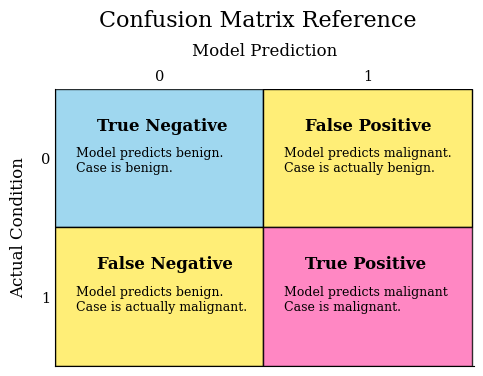

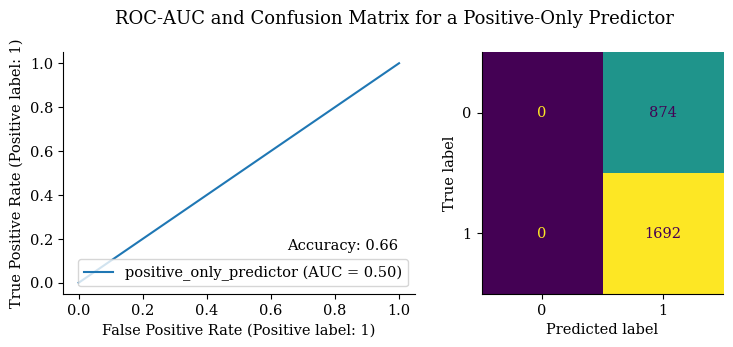

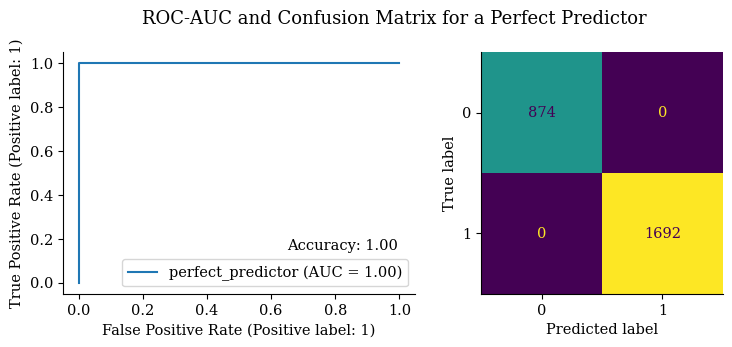

In [18]:
# Draw a confusion matrix with descriptions
fig, ax = plt.subplots(figsize=(5.4, 3.6))
ax.axvspan(0, 0.5, 0.5, 1, facecolor="skyblue", alpha=0.8, edgecolor="black")
ax.axvspan(0.5, 1, 0.5, 1, facecolor="#fe7", edgecolor="black")
ax.axvspan(0, 0.5, 0, 0.5, facecolor="#fe7", edgecolor="black")
ax.axvspan(0.5, 1, 0, 0.5, facecolor="hotpink", alpha=0.8, edgecolor="black")
ax.text(0.1, 0.85, "True Negative", size=12, weight=600)
ax.text(0.05, 0.7, "Model predicts benign.\nCase is benign.", size=9)
ax.text(0.6, 0.85, "False Positive", size=12, weight=600)
ax.text(0.55, 0.7, "Model predicts malignant.\nCase is actually benign.", size=9)
ax.text(0.1, 0.35, "False Negative", size=12, weight=600)
ax.text(0.05, 0.2, "Model predicts benign.\nCase is actually malignant.", size=9)
ax.text(0.6, 0.35, "True Positive", size=12, weight=600)
ax.text(0.55, 0.2, "Model predicts malignant\nCase is malignant.", size=9)
ax.set_xlim(0, 1.005)
ax.xaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.yaxis.set_ticklabels([1, 0])
ax.set_ylabel("Actual Condition", size=12, labelpad=10)
ax.set_xlabel("Model Prediction", size=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
ax.spines["left"].set_position("zero")
ax.tick_params(pad=0, top=False, left=False)
fig.suptitle("Confusion Matrix Reference", y=1.1, size=16)

# Plot metrics for positive-only-predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, positive_only_preds, ax=ax1,
                                         name="positive_only_predictor")
metrics.ConfusionMatrixDisplay.from_predictions(y, positive_only_preds,
                                                ax=ax2, colorbar=False)
ax1.text(0.65, 0.15,
         f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2f}")
fig.suptitle("ROC-AUC and Confusion Matrix for a Positive-Only Predictor", size=13)

# Plot metrics for "perfect" predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, y, ax=ax1, name="perfect_predictor")
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, y):.2f}")
metrics.ConfusionMatrixDisplay.from_predictions(y, y, ax=ax2, colorbar=False)
fig.suptitle("ROC-AUC and Confusion Matrix for a Perfect Predictor", size=13);

# Data Ingestion and Preprocessing
Images need to be converted into numeric form for consumption by computer vision models.

We'll use the [tensorflow image module](https://www.tensorflow.org/api_docs/python/tf/image) to:
- load the PNG image files
- decode the images and convert them to 3D tensors
- resize the images to a uniform size (some have 760x460 pixels while some have 760x456 pixels)

In [27]:
IMG_SIZE = 224
BATCH_SIZE = 28


def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label


# Prepare training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"], train["label"].map(classes), random_state=SEED
)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .map(load_image).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                  .map(load_image).batch(BATCH_SIZE)
# Prepare test dataset
test = test.sample(frac=1, random_state=SEED)  # shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices(
    (test["filename"], test["label"].map(classes))
).map(load_image).batch(BATCH_SIZE)

# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Let's looks at some of the images:

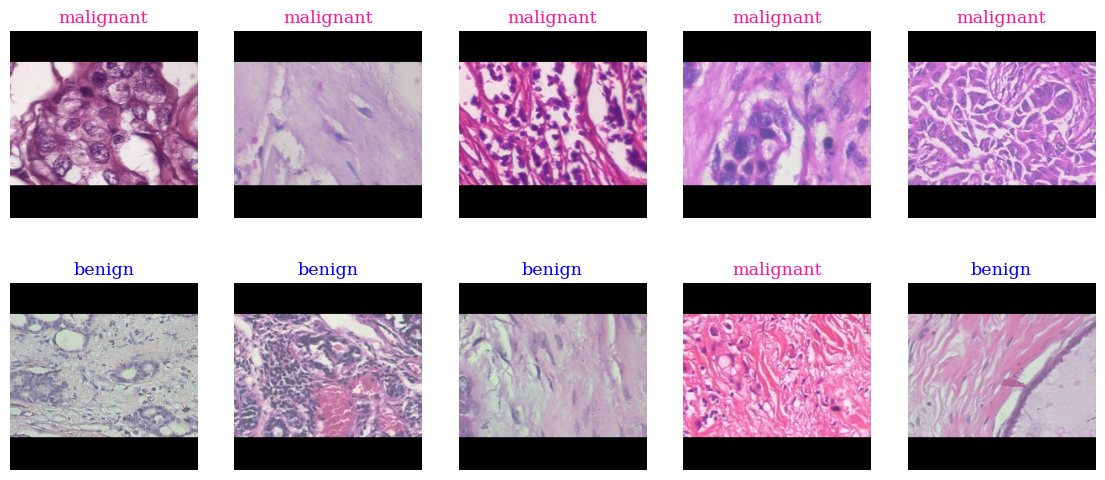

In [44]:
plt.figure(figsize=(14, 6))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        label = class_names[labels[i]]
        title_color = "blue" if label == "benign" else "deeppink"
        plt.title(class_names[labels[i]], color=title_color)
        plt.axis("off")

# Data Augmentation

[Data augmentation](https://www.datacamp.com/tutorial/complete-guide-data-augmentation) is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.  

It has the added benefit of making models robust to variations in the images. For instance, models exposed to rotated images might learn that orentation is not important when identifying cancerous cells. 

Methods used in this case include :

1. Random brightness shifts (to help address varying light conditions).
2. Random horizontal and vertical flips (to help address different orientations).
3. Random rotations (to also help address different orientations).

In [45]:
sample_image = load_image(*train[["filename", "label"]].iloc[0])[0]


def plot_augmentations(augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    ax0.imshow(sample_image.numpy().astype("uint8"))
    ax0.set_title("Original", size=14, pad=10)
    ax0.axis("off")
    for idx, ax in enumerate(axes):
        augmented_image = augmentation_layer(sample_image)
        ax.imshow(augmented_image.numpy().astype("uint8"))
        ax.set_title(augment_name.title(), size=14, pad=10)
        ax.axis("off")

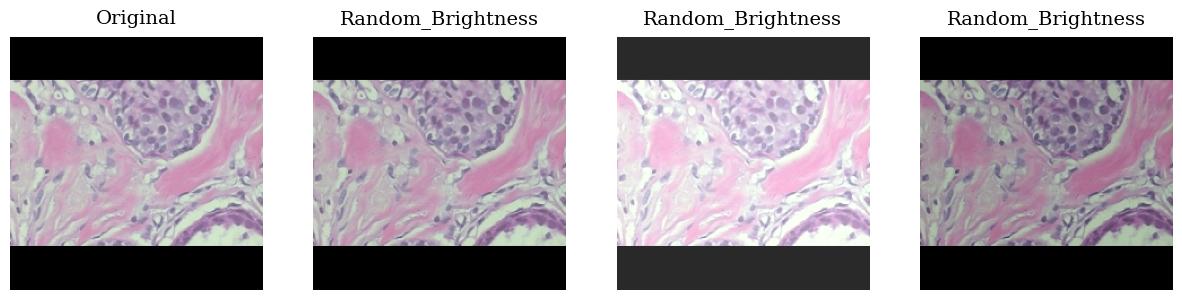

In [46]:
plot_augmentations(layers.RandomBrightness(0.2))

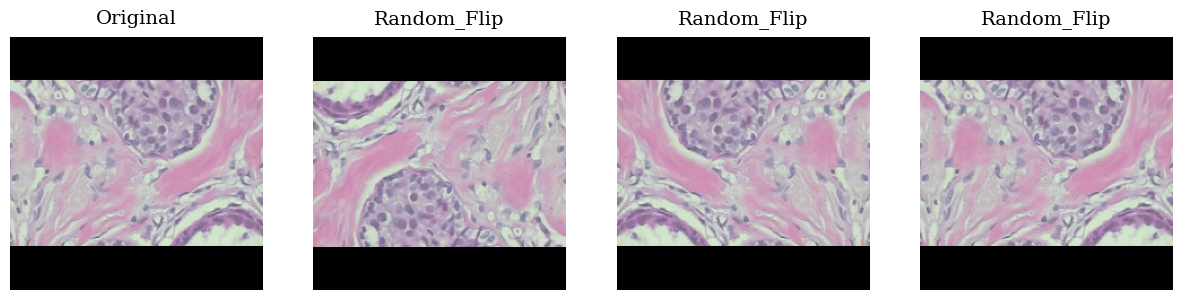

In [47]:
plot_augmentations(layers.RandomFlip())

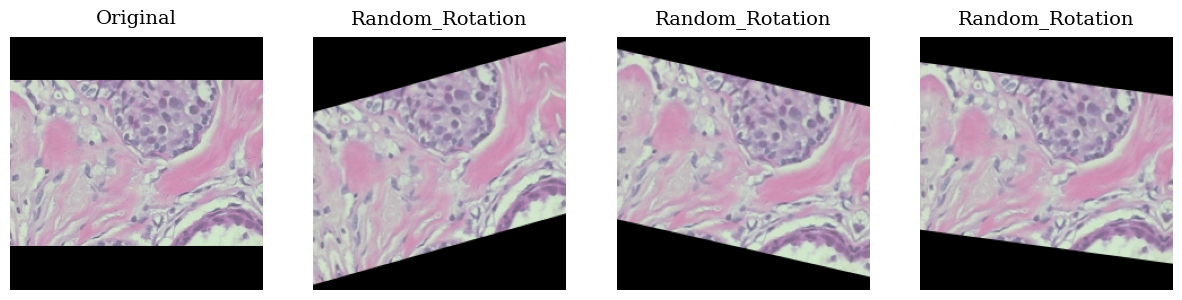

In [48]:
plot_augmentations(layers.RandomRotation(0.2, seed=SEED))

# Helper functions

In [60]:
MAX_EPOCHS = 25
BASE_LEARNING_RATE = 0.001


def compile_and_fit_model(
    model: tf.keras.Model,
    learning_rate: float=BASE_LEARNING_RATE,
    epochs: int=MAX_EPOCHS
) -> tf.keras.callbacks.History:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"]
    )
    early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1,
                                   restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)
    history = model.fit(train_ds, validation_data=validation_ds,
                        epochs=epochs, callbacks=[early_stopping, reduce_lr])
    # Plot training metrics
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
    for ax, metric in zip(axes.flat, ["Accuracy", "Loss"]):
        performance_df.filter(like=metric.lower()).plot(ax=ax)
        ax.set_title(metric, size=14, pad=10)
        ax.set_xlabel("epoch")
    return history


def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset=test_ds) -> None:
    loss, auc, accuracy = model.evaluate(dataset, verbose=0)
    print(f"\nROC-AUC:   {auc:.5f}", 
          f"Accuracy:  {accuracy:.5f}",
          f"Loss:      {loss:.5f}\n", sep="\n")
    # Get labels and predictions for each batch in dataset
    results = [(labels, model.predict(images, verbose=0).reshape(-1))
               for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results])
    # Plot metrics
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
    for ax, curve in zip(axes[:2], curves):
        curve.from_predictions(labels, preds, ax=ax, name=model.name)
    metrics.ConfusionMatrixDisplay.from_predictions(
        labels, preds.round().astype("uint8"), ax=axes[2], colorbar=False,
    )
    titles = ["ROC-AUC Curve", "Precision-Recall Curve", "Confusion Matrix"]
    for ax, title in zip(axes.flat, titles):
        ax.set_title(title, size=14, pad=10)


def plot_predictions(model: tf.keras.Model) -> None:
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1,)
        print("Predicted:", predicted_labels)
        print("Actual:   ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_names[predicted_labels[i]]}\n"
                          + f"(Actual: {class_names[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

# Custom Convolutional Neural Network

A [Convolutional Neural Network](https://www.ibm.com/topics/convolutional-neural-networks) (CNN) is a class of artifical neural networks that is well suited for computer vision problems. In neural networks, there are different layers of nodes. These nodes receive information, process it, and pass it on to the next layer. Each connection between nodes has a certain importance, called a weight. If a node's output meets a certain requirement, it gets activated and passes its information along. Otherwise, it doesn't pass anything to the next layer. This process helps the network learn and make decisions. It excels at finding patterns in images. 

In simple terms, a neural network is like a digital brain that learns from examples to figure things out, just as we do when we learn new things. Imagine you want to teach a computer to recognize different types of fruits. You'd start by showing it lots of pictures of fruits like apples, oranges, and bananas. Each picture goes into the neural network, and the neurons start to work.
At first, the network doesn't know much, like a baby learning about fruits. But as it sees more pictures and gets feedback (correct or incorrect guesses), it adjusts itself. It tries to identify patterns – like the shape, color, or texture of each fruit.

In [62]:
custom_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # Convolutional block I
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block II
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block III
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Fully connected layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="CustomCNN")
custom_model.summary()

Model: "CustomCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_6 (Rando  (None, 224, 224, 3)       0         
 mBrightness)                                                    
                                                                 
 random_flip_6 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_6 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 batch_normalization_5 (Bat  (None, 224, 224, 3)       12        
 chNormalization)                                                
                                                         

Epoch 1/25
69/69 [==============================] - 159s 2s/step - loss: 0.5611 - roc_auc: 0.7489 - binary_accuracy: 0.7214 - val_loss: 0.5287 - val_roc_auc: 0.8703 - val_binary_accuracy: 0.6760 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 154s 2s/step - loss: 0.4485 - roc_auc: 0.8510 - binary_accuracy: 0.8269 - val_loss: 0.5443 - val_roc_auc: 0.8845 - val_binary_accuracy: 0.6636 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 143s 2s/step - loss: 0.4277 - roc_auc: 0.8645 - binary_accuracy: 0.8399 - val_loss: 0.4150 - val_roc_auc: 0.8769 - val_binary_accuracy: 0.8411 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 143s 2s/step - loss: 0.4260 - roc_auc: 0.8622 - binary_accuracy: 0.8363 - val_loss: 0.3932 - val_roc_auc: 0.8817 - val_binary_accuracy: 0.8614 - lr: 0.0010
Epoch 5/25
69/69 [==============================] - 143s 2s/step - loss: 0.4237 - roc_auc: 0.8648 - binary_accuracy: 0.8290 - val_loss: 0.3751 - val_roc_auc: 0.8927 - v

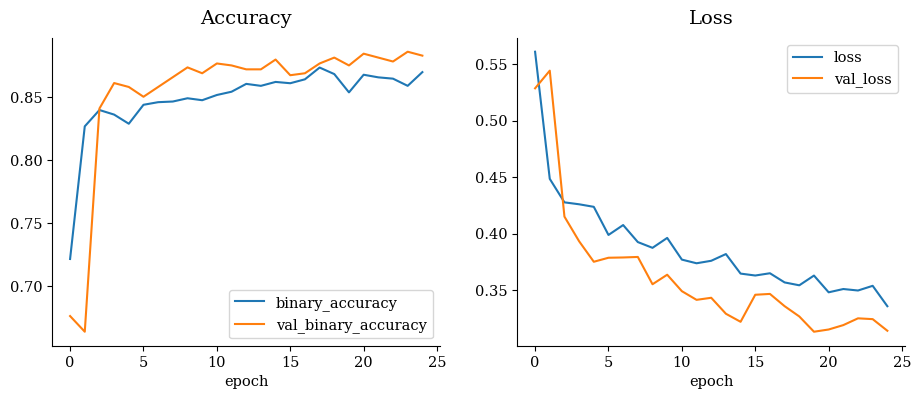

In [63]:
custom_history = compile_and_fit_model(custom_model)


ROC-AUC:   0.83479
Accuracy:  0.83899
Loss:      0.52116



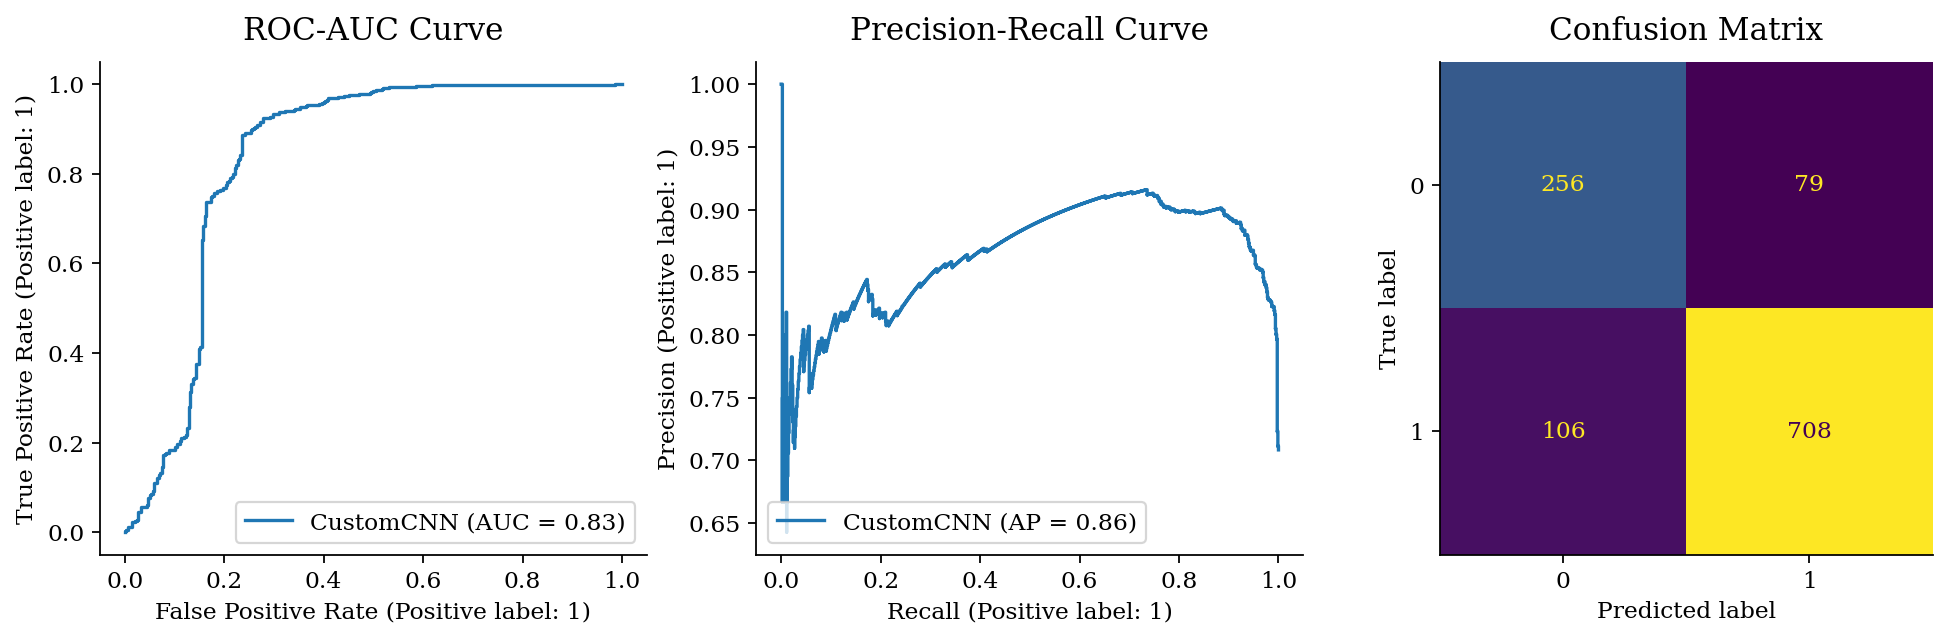

In [64]:
evaluate_model(custom_model)

The overall performance is quite good for a light-weight custom CNN trained on a quite limited set of data. That being said, there are relatively few *false positives* (79) and *false negatives* (106)

1/1 [==============================] - 1s 560ms/step
Predicted: [0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1]
Actual:    [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1]


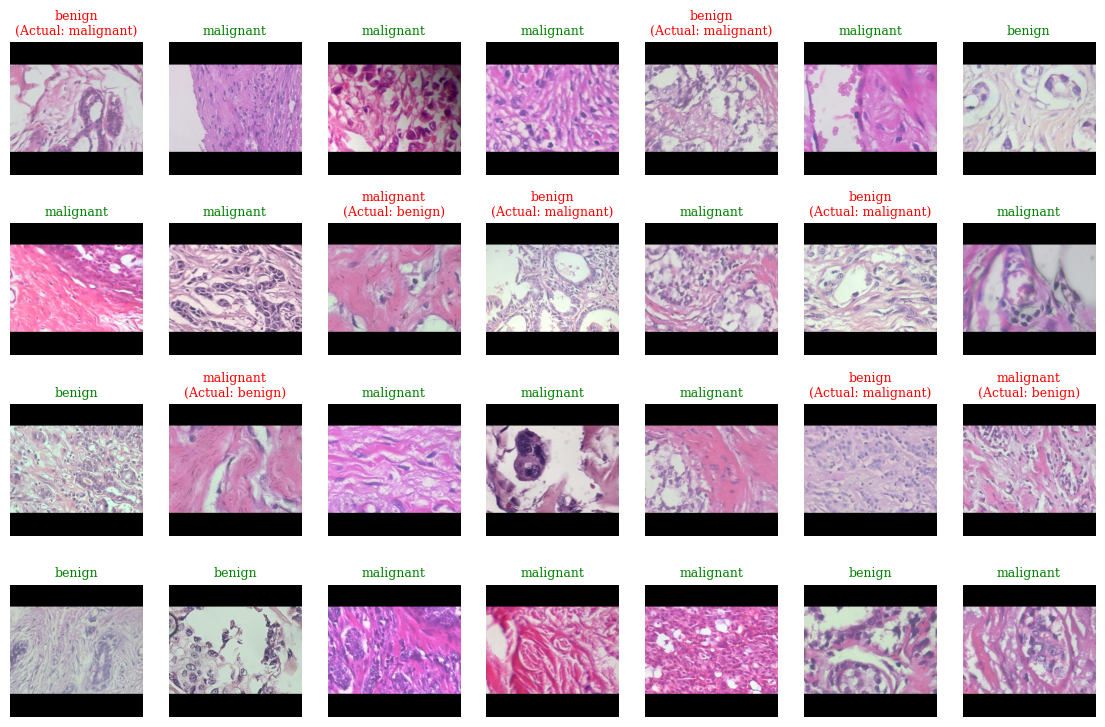

In [65]:
plot_predictions(custom_model)

# Transfer Learning

[Transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/) is the practice of applying knowledge acquired from one task to another related task. It is widely used in computer vision problems to obtain high performance with little data, by leveraging pre-trained models that have learnt how to extract features from massive collections of images.

In simple terms, Here's how it works:

Applying Knowledge: Imagine you want to bake a chocolate cake or a strawberry cake. Instead of starting from scratch and learning a completely new recipe, you take your basic vanilla cake recipe and just make a few changes, like adding cocoa powder for a chocolate cake or strawberries for a strawberry cake.

In the same way, transfer learning in machine learning is like using knowledge gained from solving one problem and applying it to a different but related problem. Instead of starting from zero to train a new model for a different task, you start with a pre-trained model (like your basic cake recipe) and adjust or fine-tune it with new data or specific tweaks for the new task. This saves time and resources because you're not building everything from the ground up every time you face a new problem.

Let's see how some of the most popular model architectures perform on this dataset:

## Model with MobileNetV3 base

In [66]:
pretrained_mobnet_base = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_mobnet_base.trainable = False

mobnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # MobileNet
    layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    pretrained_mobnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="MobileNetV3")
mobnet_model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "MobileNetV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_7 (Rando  (None, 224, 224, 3)       0         
 mBrightness)                                                    
                                                                 
 random_flip_7 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_7 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                    

Epoch 1/25
69/69 [==============================] - 62s 803ms/step - loss: 0.6199 - roc_auc: 0.6592 - binary_accuracy: 0.6772 - val_loss: 0.5122 - val_roc_auc: 0.7980 - val_binary_accuracy: 0.7212 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 62s 905ms/step - loss: 0.5407 - roc_auc: 0.7654 - binary_accuracy: 0.7240 - val_loss: 0.5086 - val_roc_auc: 0.8115 - val_binary_accuracy: 0.7274 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 62s 909ms/step - loss: 0.4952 - roc_auc: 0.8101 - binary_accuracy: 0.7568 - val_loss: 0.4306 - val_roc_auc: 0.8706 - val_binary_accuracy: 0.7741 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 53s 767ms/step - loss: 0.4843 - roc_auc: 0.8231 - binary_accuracy: 0.7682 - val_loss: 0.4360 - val_roc_auc: 0.8734 - val_binary_accuracy: 0.7897 - lr: 0.0010
Epoch 5/25
69/69 [==============================] - 62s 908ms/step - loss: 0.4437 - roc_auc: 0.8532 - binary_accuracy: 0.7833 - val_loss: 0.4273 - val_roc_auc: 

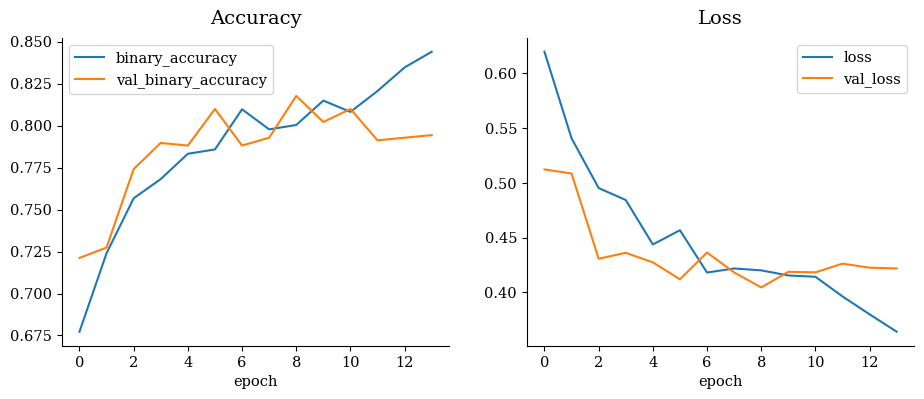

In [67]:
mobnet_history = compile_and_fit_model(mobnet_model)


ROC-AUC:   0.74763
Accuracy:  0.71889
Loss:      0.57225



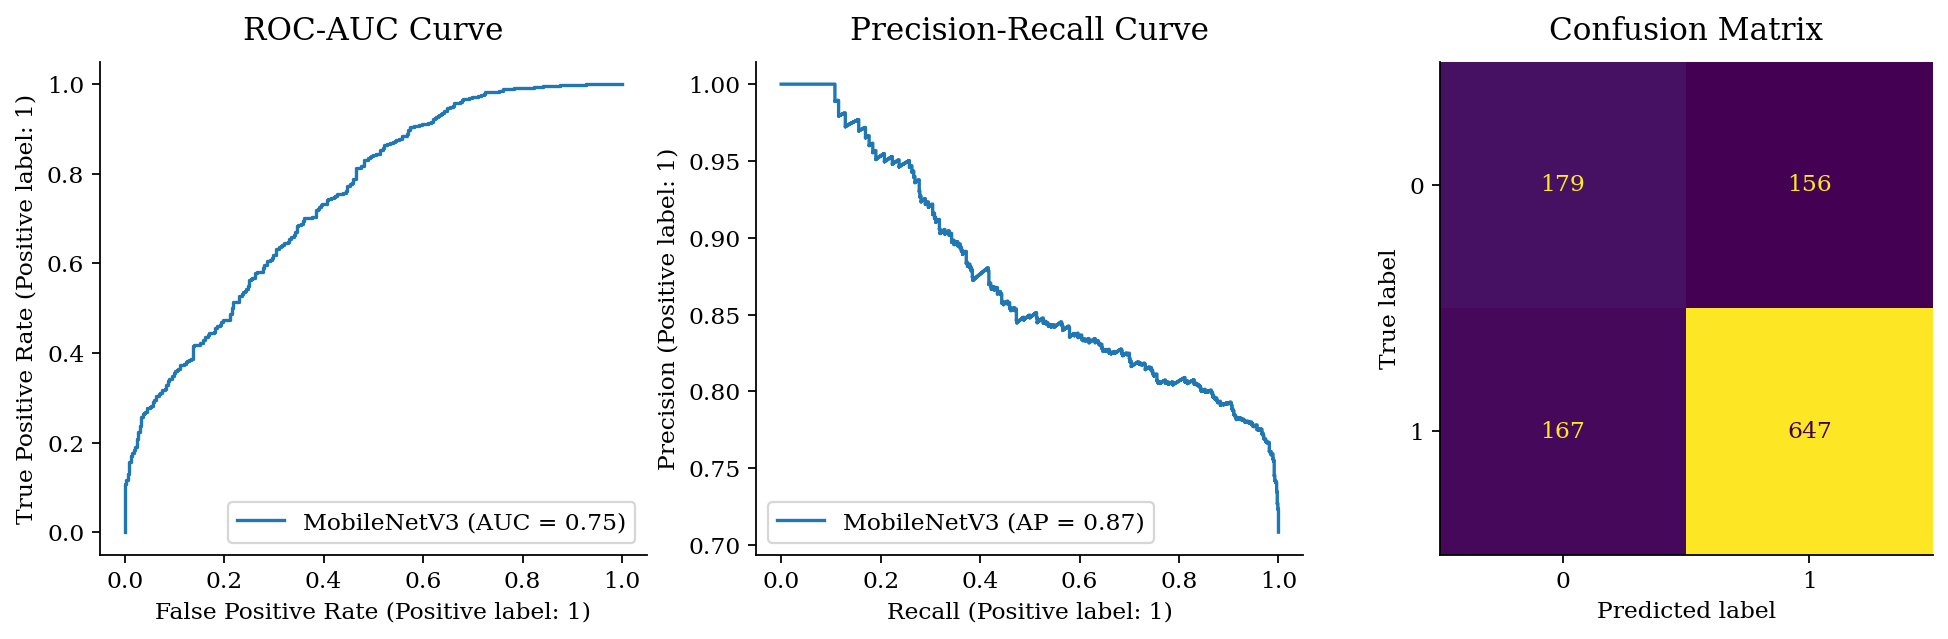

In [68]:
evaluate_model(mobnet_model)

In [ ]:
plot_predictions(mobnet_model)

## Model with EfficientNetB1 base
EfficientNet paper: https://arxiv.org/abs/1905.11946

In [ ]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=False, 
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # EfficientNet
    pretrained_efficientnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="EfficientNetB1")
efficientnet_model.summary()

In [ ]:
efficientnet_history = compile_and_fit_model(efficientnet_model)

In [ ]:
evaluate_model(efficientnet_model)

In [ ]:
plot_predictions(efficientnet_model)

## Model with VGG16 base

VGG paper: https://arxiv.org/abs/1409.1556

In [ ]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg"
)
pretrained_vgg16_base.trainable = False

vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # VGG16
    layers.Lamba(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(384, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="VGG16")
vgg16_model.summary()

In [ ]:
vgg16_history = compile_and_fit_model(vgg16_model)

In [ ]:
evaluate_model(vgg16_model)

In [ ]:
plot_predictions(vgg16_model)

## Model with ResNet50V2 base
ResNetV2 paper: https://arxiv.org/abs/1603.05027

In [ ]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_resnet_base.trainable = False

resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # ResNet
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dropout(0.4),
    # Fully connected layers
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="ResNet50V2")
resnet_model.summary()

In [ ]:
resnet_history = compile_and_fit_model(resnet_model)

In [ ]:
evaluate_model(resnet_model)

In [ ]:
plot_predictions(resnet_model)

# Ensemble
> *The whole is greater than the sum of its parts."* -Aristotle

Machine learning models can be combined into a composite model that is often better than any individual modeel or so in theory. This is referred to as [Ensembling](https://en.wikipedia.org/wiki/Ensemble_learning).

Common ensembling techniques include: 

1. **Bagging:** Fitting several "whole/full" models on subsets of the data, then aggregating their results. e.g, A Random-forest consists of several decision tree models.
2. **Boosting:** Starts with a "weak/shallow" model, then successively adds weak models focused of portions of the data that the overall model is performing poorly on. e.g, a Gradient-boosting model consists of several shallow decision tree models.
3. **Stacking:** Using predicitons from several models as inputs to a final estimator.

Let investigate if stacking can be used in this case to further improve the results: 

In [ ]:
def get_predictions_and_labels(dataset: tf.data.Dataset) -> Tuple:
    # Get labels and predictions for each batch in dataset
    results = [(labels, [model.predict(images, verbose=0).reshape(-1,)
                        for model in fitted_models])
              for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    # Combine predictions, then transpose to shape (nsamples, nmodels)
    preds = np.concatenate([x[1] for x in results], axis=1).transpose()
    return preds, labels


train_preds, train_labels = get_predictions_and_labels(train_ds)
valid_preds, valid_labels = get_predictions_and_labels(validation_ds)
test_preds, test_labels = get_predictions_and_labels(test_ds)

In [ ]:
stacking_model = LogisticRegressionCV(scoring="roc_auc")
stacking_model.fit(train_preds, train_labels)
staced_preds = stacking_model.predict_proba(test_preds)

test_metrics["Stacking Ensemble"] = [
    metrics.log_loss(test_labels, stacked_preds),
    metrics.roc_auc_score(test_labels,
                         stacked_preds[:, 1]), # get stacked +ve probability
    metrics.accuracy_score(test_labels,
                          stacked_preds.argmax(axis=1)) # get stacked predicted label
    
]
test_metrics.style.highlight_min(color="gold", axis=None)\
                  .highlight_max(color="lawngreen", axis=None)

The stacked ensemble significantly improves the test ROC-AUC score, but the EfficinetNetB1 model still yields the least loss

In [ ]:
# Store models for deployment
custom_model.save("custom_cnn.h5")
mobnet_model.save("mobnetv3sm.h5")
efficientnet_model.save("efficientnetv2B1.h5")
vgg16_model.save("vgg16.h5")
resnet_model.save("resnet50v2.h5")

!du -h * .h5 # view file size